In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 12.5 MB/s eta 0:00:0000:01


In [2]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 2.8 MB/s eta 0:00:00


In [3]:
from warnings import filterwarnings
filterwarnings(action="ignore")
import os
import yaml
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import supervision as sv
from ultralytics import YOLO

from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

2024-03-11 21:57:47.774462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 21:57:47.774601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 21:57:47.948233: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
annotated = r"/kaggle/input/football-live-match-object-detection-annotated/Annotated"

data = {"images":[], "labels":[], "split_type":[]}
 
for dir_name in os.listdir(annotated): # Split Type
    split_type = os.path.join(annotated, dir_name)
    for dir_1 in os.listdir(split_type):
        if dir_1 == "images":
            images = os.path.join(split_type, dir_1)
            for dir_2 in os.listdir(images):
                image_path = os.path.join(images, dir_2)
                data["images"].append(image_path)
                data["split_type"].append(dir_name)
        else:
            labels = os.path.join(split_type, dir_1)
            for dir_2 in os.listdir(labels):
                label_path = os.path.join(labels, dir_2)
                data["labels"].append(label_path)
                
football_data = pd.DataFrame(data)

print("Shape:", football_data.shape)

football_data.head()

Shape: (98, 3)


,images,labels,split_type
0,/kaggle/input/football-live-match-object-detec...,/kaggle/input/football-live-match-object-detec...,test
1,/kaggle/input/football-live-match-object-detec...,/kaggle/input/football-live-match-object-detec...,test
2,/kaggle/input/football-live-match-object-detec...,/kaggle/input/football-live-match-object-detec...,test
3,/kaggle/input/football-live-match-object-detec...,/kaggle/input/football-live-match-object-detec...,test
4,/kaggle/input/football-live-match-object-detec...,/kaggle/input/football-live-match-object-detec...,test


In [5]:
for index, labels in enumerate(football_data["labels"]):
    if len(np.loadtxt(labels)) == 0:
        football_data.loc[index, "is_annotated"] = False
    else:
        football_data.loc[index, "is_annotated"] = True

In [6]:
football_data[football_data["is_annotated"] == False]

,images,labels,split_type,is_annotated


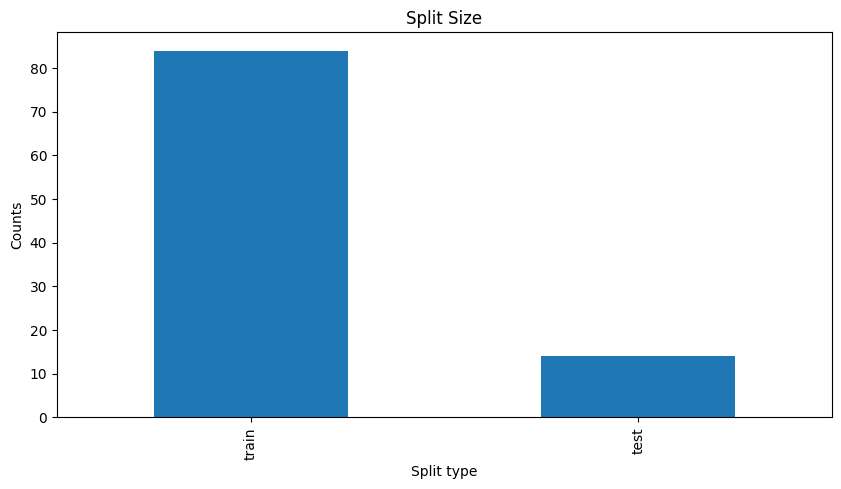

In [7]:
football_data["split_type"].value_counts().plot(kind="bar", 
                                                xlabel="Split type", 
                                                ylabel="Counts",
                                                title="Split Size",
                                                figsize=(10, 5))
plt.show()

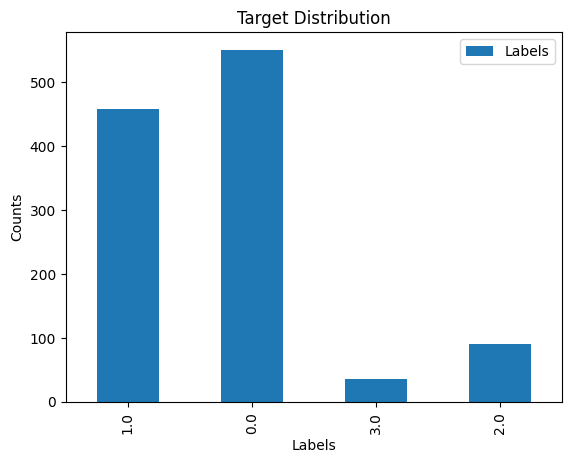

In [8]:
from collections import Counter

annotations = []
for label_link in football_data["labels"]:
    annotations.extend([i[0] for i in np.loadtxt(label_link)])
    
pd.DataFrame({str(key):[value] for key, value in Counter(annotations).items()}).T.rename({0:"Labels"}, axis=1).plot(kind="bar", 
                                                                                                                    title="Target Distribution",
                                                                                                                    xlabel="Labels",
                                                                                                                    ylabel="Counts")

plt.show()

In [9]:
Xtrain, Xtest = train_test_split(football_data, test_size=0.1, random_state=42)

Xtest, Xval = train_test_split(Xtest, test_size=0.4, random_state=42)

print(Xtrain.shape, Xtest.shape, Xval.shape)

(88, 4) (6, 4) (4, 4)


In [10]:
os.makedirs("train/images")
os.makedirs("train/labels")
os.makedirs("test/images")
os.makedirs("test/labels")
os.makedirs("val/images")
os.makedirs("val/labels")

In [11]:
import shutil

for image, label in zip(Xtrain["images"], Xtrain["labels"]):
    shutil.copy(src=image, dst="/kaggle/working/train/images")
    shutil.copy(src=label, dst="/kaggle/working/train/labels")

for image, label in zip(Xtest["images"], Xtest["labels"]):
    shutil.copy(src=image, dst="/kaggle/working/test/images")
    shutil.copy(src=label, dst="/kaggle/working/test/labels")

for image, label in zip(Xval["images"], Xval["labels"]):
    shutil.copy(src=image, dst="/kaggle/working/val/images")
    shutil.copy(src=label, dst="/kaggle/working/val/labels")

In [12]:
data = {"nc":4,
        "names":["Category 1", "Category 2", "Category 3", "Category 4"],
        "train":"/kaggle/working/train",
        "test":"/kaggle/working/test",
        "val":"/kaggle/working/val"}

with open("data.yaml", "w+") as file:
    yaml.dump(data, file, default_flow_style=True)

In [14]:
pre_trained_model = YOLO("yolov8n.pt")


pre_trained_model.train(data="/kaggle/working/data.yaml", 
                        imgsz=,
                        epochs=20)

# Other parameters 
# learning_rate (lr), dropout, batch

Ultralytics YOLOv8.1.27 🚀 Python-3.10.13 torch-2.1.2+cpu CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=600, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
WARNING ⚠️ imgsz=[600] must be multiple of max stride 32, updating to [608]


train: Scanning /kaggle/working/train/labels... 80 images, 8 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<00:00, 1509.04it/s]

train: New cache created: /kaggle/working/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/val/labels... 1 images, 3 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 5500.73it/s]

val: New cache created: /kaggle/working/val/labels.cache
Plotting labels to runs/detect/train2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      2.574      4.423       1.45         72        608: 100%|██████████| 6/6 [00:45<00:00,  7.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all          4         14          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      2.217      4.016       1.28         63        608: 100%|██████████| 6/6 [00:34<00:00,  5.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all          4         14          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      2.258       3.01      1.236        121        608: 100%|██████████| 6/6 [00:34<00:00,  5.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all          4         14          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      2.196      2.472      1.199         75        608: 100%|██████████| 6/6 [00:35<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all          4         14    0.00234      0.136    0.00633    0.00143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G       2.16       2.15      1.181        155        608: 100%|██████████| 6/6 [00:34<00:00,  5.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all          4         14    0.00718      0.314     0.0177    0.00405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      2.133      2.006      1.222         65        608: 100%|██████████| 6/6 [00:34<00:00,  5.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all          4         14     0.0089      0.464     0.0453      0.015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      2.154      1.913      1.234         82        608: 100%|██████████| 6/6 [00:34<00:00,  5.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all          4         14    0.00875       0.45     0.0639     0.0189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      2.159      1.782      1.235         85        608: 100%|██████████| 6/6 [00:33<00:00,  5.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          4         14    0.00842       0.45     0.0585     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      2.124      1.725      1.222         80        608: 100%|██████████| 6/6 [00:35<00:00,  5.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all          4         14    0.00834      0.664      0.116     0.0353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      2.026      1.696      1.201        153        608: 100%|██████████| 6/6 [00:34<00:00,  5.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all          4         14     0.0105       0.75       0.14     0.0508


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      2.027      1.693      1.246         83        608: 100%|██████████| 6/6 [00:36<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          4         14     0.0112       0.75      0.116     0.0468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      2.051      1.638       1.27         59        608: 100%|██████████| 6/6 [00:32<00:00,  5.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          4         14      0.322        0.5       0.11     0.0476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.973      1.548      1.251         91        608: 100%|██████████| 6/6 [00:32<00:00,  5.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all          4         14      0.529     0.0714      0.185     0.0802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.946      1.593      1.235         92        608: 100%|██████████| 6/6 [00:33<00:00,  5.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all          4         14      0.538      0.107      0.188     0.0655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.962      1.465      1.216         91        608: 100%|██████████| 6/6 [00:33<00:00,  5.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all          4         14      0.298      0.143      0.197     0.0728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.944      1.503      1.219         85        608: 100%|██████████| 6/6 [00:33<00:00,  5.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all          4         14      0.416      0.564      0.401      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.884      1.444      1.227         72        608: 100%|██████████| 6/6 [00:33<00:00,  5.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all          4         14      0.425      0.615      0.285      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.926      1.453      1.243         66        608: 100%|██████████| 6/6 [00:32<00:00,  5.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all          4         14      0.459      0.723      0.281      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.869      1.422      1.203         92        608: 100%|██████████| 6/6 [00:32<00:00,  5.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all          4         14      0.459      0.714      0.428      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.879      1.413      1.184         84        608: 100%|██████████| 6/6 [00:32<00:00,  5.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          4         14      0.469      0.714       0.33      0.178



20 epochs completed in 0.205 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.10.13 torch-2.1.2+cpu CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


                   all          4         14      0.459      0.714      0.428       0.17
            Category 1          4          5      0.213          1      0.271      0.158
            Category 2          4          7      0.216      0.857      0.427       0.22
            Category 3          4          1      0.407          1      0.995      0.298
            Category 4          4          1          1          0     0.0203    0.00203
Speed: 1.8ms preprocess, 128.9ms inference, 0.0ms loss, 13.6ms postprocess per image
Results saved to runs/detect/train2


lr/pg0,▁▂▄▅▆▆▇▇█████▇▇▆▅▅▄▂
lr/pg1,▁▂▄▅▆▆▇▇█████▇▇▆▅▅▄▂
lr/pg2,▁▂▄▅▆▆▇▇█████▇▇▆▅▅▄▂
metrics/mAP50(B),▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄█▆▆██
metrics/mAP50-95(B),▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄█▇▇██
metrics/precision(B),▁▁▁▁▁▁▁▁▁▁▁▅██▅▆▇▇▇▇
metrics/recall(B),▁▁▁▂▄▅▅▅▇██▆▂▂▂▆▇███
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▄▅▄▄▄▄▄▄▃▃▃▂▂▂▂▁▂▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d3935dc9630>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0